<!-- dom:TITLE: Data Analysis and Machine Learning: From Decision Trees to Forests and all that -->
# Data Analysis and Machine Learning: From Decision Trees to Forests and all that
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Nov 5, 2019**

Copyright 1999-2019, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license




## Decision trees, overarching aims


Decision trees are supervised learning algorithms used for both,
classification and regression tasks.


The main idea of decision trees
is to find those descriptive features which contain the most
**information** regarding the target feature and then split the dataset
along the values of these features such that the target feature values
for the resulting underlying datasets are as pure as possible.

The descriptive features which reproduce best the target/output features are normally  said
to be the most informative ones. The process of finding the **most
informative** feature is done until we accomplish a stopping criteria
where we then finally end up in so called **leaf nodes**. 

A decision tree is typically divided into a **root node**, the **interior nodes**,
and the final **leaf nodes** or just **leaves**. These entities are then connected by so-called **branches**.

The leaf nodes
contain the predictions we will make for new query instances presented
to our trained model. This is possible since the model has 
learned the underlying structure of the training data and hence can,
given some assumptions, make predictions about the target feature value
(class) of unseen query instances.

## A typical Decision Tree with its pertinent Jargon, Classification Problem

<!-- dom:FIGURE: [DataFiles/cancer.png, width=600 frac=0.8] -->
<!-- begin figure -->

<p></p>
<img src="DataFiles/cancer.png" width=600>

<!-- end figure -->


This tree was produced using the Wisconsin cancer data (discussed here as well, see code examples below) using **Scikit-Learn**'s decision tree classifier. Here we have used the so-called **gini** index (see below) to split the various branches.



## General Features

The overarching approach to decision trees is a top-down approach.

* A leaf provides the classification of a given instance.

* A node specifies a test of some attribute of the instance.

* A branch corresponds to a possible values of an attribute.

* An instance is classified by starting at the root node of the tree, testing the attribute specified by this node, then moving down the tree branch corresponding to the value of the attribute in the given example.

This process is then repeated for the subtree rooted at the new
node.


## How do we set it up?


In simplified terms, the process of training a decision tree and
predicting the target features of query instances is as follows:

1. Present a dataset containing of a number of training instances characterized by a number of descriptive features and a target feature

2. Train the decision tree model by continuously splitting the target feature along the values of the descriptive features using a measure of information gain during the training process

3. Grow the tree until we accomplish a stopping criteria create leaf nodes which represent the *predictions* we want to make for new query instances

4. Show query instances to the tree and run down the tree until we arrive at leaf nodes

Then we are essentially done!





## Decision trees and Regression

2nd degree coefficients:
zero power:  -0.28499417022929907
first power:  0.05490242306549711
second power:  -0.0002577121418274489


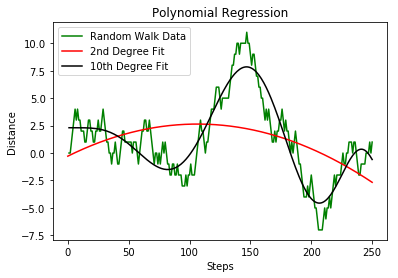

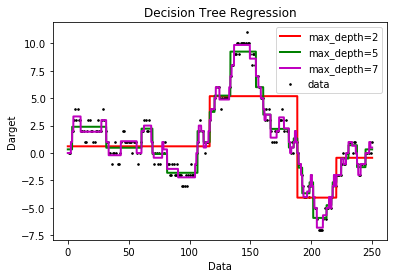

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

steps=250

distance=0
x=0
distance_list=[]
steps_list=[]
while x<steps:
    distance+=np.random.randint(-1,2)
    distance_list.append(distance)
    x+=1
    steps_list.append(x)
plt.plot(steps_list,distance_list, color='green', label="Random Walk Data")

steps_list=np.asarray(steps_list)
distance_list=np.asarray(distance_list)

X=steps_list[:,np.newaxis]

#Polynomial fits

#Degree 2
poly_features=PolynomialFeatures(degree=2, include_bias=False)
X_poly=poly_features.fit_transform(X)

lin_reg=LinearRegression()
poly_fit=lin_reg.fit(X_poly,distance_list)
b=lin_reg.coef_
c=lin_reg.intercept_
print ("2nd degree coefficients:")
print ("zero power: ",c)
print ("first power: ", b[0])
print ("second power: ",b[1])

z = np.arange(0, steps, .01)
z_mod=b[1]*z**2+b[0]*z+c

fit_mod=b[1]*X**2+b[0]*X+c
plt.plot(z, z_mod, color='r', label="2nd Degree Fit")
plt.title("Polynomial Regression")

plt.xlabel("Steps")
plt.ylabel("Distance")

#Degree 10
poly_features10=PolynomialFeatures(degree=10, include_bias=False)
X_poly10=poly_features10.fit_transform(X)

poly_fit10=lin_reg.fit(X_poly10,distance_list)

y_plot=poly_fit10.predict(X_poly10)
plt.plot(X, y_plot, color='black', label="10th Degree Fit")

plt.legend()
plt.show()


#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
regr_1=DecisionTreeRegressor(max_depth=2)
regr_2=DecisionTreeRegressor(max_depth=5)
regr_3=DecisionTreeRegressor(max_depth=7)
regr_1.fit(X, distance_list)
regr_2.fit(X, distance_list)
regr_3.fit(X, distance_list)

X_test = np.arange(0.0, steps, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3=regr_3.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, distance_list, s=2.5, c="black", label="data")
plt.plot(X_test, y_1, color="red",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="green", label="max_depth=5", linewidth=2)
plt.plot(X_test, y_3, color="m", label="max_depth=7", linewidth=2)

plt.xlabel("Data")
plt.ylabel("Darget")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Building a tree, regression

There are mainly two steps
1. We split the predictor space (the set of possible values $x_1,x_2,\dots, x_p$) into $J$ distinct and non-non-overlapping regions, $R_1,R_2,\dots,R_J$.  

2. For every observation that falls into the region $R_j$ , we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

How do we construct the regions $R_1,\dots,R_J$?  In theory, the
regions could have any shape. However, we choose to divide the
predictor space into high-dimensional rectangles, or boxes, for
simplicity and for ease of interpretation of the resulting predictive
model. The goal is to find boxes $R_1,\dots,R_J$ that minimize the
MSE, given by

$$
\sum_{j=1}^J\sum_{i\in R_j}(y_i-\overline{y}_{R_j})^2,
$$

where $\overline{y}_{R_j}$  is the mean response for the training observations 
within box $j$. 

## A top-down approach, recursive binary splitting

Unfortunately, it is computationally infeasible to consider every
possible partition of the feature space into $J$ boxes.  The common
strategy is to take a top-down approach

The approach is top-down because it begins at the top of the tree (all
observations belong to a single region) and then successively splits
the predictor space; each split is indicated via two new branches
further down on the tree. It is greedy because at each step of the
tree-building process, the best split is made at that particular step,
rather than looking ahead and picking a split that will lead to a
better tree in some future step.

## Making a tree

In order to implement the recursive binary splitting we start by selecting
the predictor $x_j$ and a cutpoint $s$ that splits the predictor space into two regions $R_1$ and $R_2$

$$
\left\{X\vert x_j < s\right\},
$$

and

$$
\left\{X\vert x_j \geq s\right\},
$$

so that we obtain the lowest MSE, that is

$$
\sum_{i:x_i\in R_j}(y_i-\overline{y}_{R_1})^2+\sum_{i:x_i\in R_2}(y_i-\overline{y}_{R_2})^2,
$$

which we want to minimize by considering all predictors
$x_1,x_2,\dots,x_p$.  We consider also all possible values of $s$ for
each predictor. These values could be determined by randomly assigned
numbers or by starting at the midpoint and then proceed till we find
an optimal value.

For any $j$ and $s$, we define the pair of half-planes where
$\overline{y}_{R_1}$ is the mean response for the training
observations in $R_1(j,s)$, and $\overline{y}_{R_2}$ is the mean
response for the training observations in $R_2(j,s)$.

Finding the values of $j$ and $s$ that minimize the above equation can be
done quite quickly, especially when the number of features $p$ is not
too large.

Next, we repeat the process, looking
for the best predictor and best cutpoint in order to split the data
further so as to minimize the MSE within each of the resulting
regions. However, this time, instead of splitting the entire predictor
space, we split one of the two previously identified regions. We now
have three regions. Again, we look to split one of these three regions
further, so as to minimize the MSE. The process continues until a
stopping criterion is reached; for instance, we may continue until no
region contains more than five observations.

<!-- !split  -->
## Pruning the tree

The above procedure is rather straightforward, but leads often to
overfitting and unnecessarily large and complicated trees. The basic
idea is to grow a large tree $T_0$ and then prune it back in order to
obtain a subtree. A smaller tree with fewer splits (fewer regions) can
lead to smaller variance and better interpretation at the cost of a
little more bias.

The so-called Cost complexity pruning algorithm gives us a
way to do just this. Rather than considering every possible subtree,
we consider a sequence of trees indexed by a nonnegative tuning
parameter $\alpha$.

## Cost complexity pruning
For each value of $\alpha$  there corresponds a subtree $T \in T_0$ such that

$$
\sum_{m=1}^{\overline{T}}\sum_{i:x_i\in R_m}(y_i-\overline{y}_{R_m})^2+\alpha\overline{T},
$$

is as small as possible. Here $\overline{T}$ is 
the number of terminal nodes of the tree $T$ , $R_m$ is the
rectangle (i.e. the subset of predictor space)  corresponding to the $m$-th terminal node.

The tuning parameter $\alpha$ controls a trade-off between the subtree’s
com- plexity and its fit to the training data. When $\alpha = 0$, then the
subtree $T$ will simply equal $T_0$, 
because then the above equation just measures the
training error. 
However, as $\alpha$ increases, there is a price to pay for
having a tree with many terminal nodes. The above equation will
tend to be minimized for a smaller subtree. 


It turns out that as we increase $\alpha$ from zero
branches get pruned from the tree in a nested and predictable fashion,
so obtaining the whole sequence of subtrees as a function of $\alpha$ is
easy. We can select a value of $\alpha$ using a validation set or using
cross-validation. We then return to the full data set and obtain the
subtree corresponding to $\alpha$. 


## Schematic Regression Procedure

**Building a Regression Tree.**

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.

2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.

3. Use for example $K$-fold cross-validation to choose $\alpha$. Divide the training observations into $K$ folds. For each $k=1,2,\dots,K$ we: 

  * repeat steps 1 and 2 on all but the $k$-th fold of the training data. 

  * Then we valuate the mean squared prediction error on the data in the left-out $k$-th fold, as a function of $\alpha$.

  * Finally  we average the results for each value of $\alpha$, and pick $\alpha$ to minimize the average error.


4. Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$.




## A Classification Tree

A classification tree is very similar to a regression tree, except
that it is used to predict a qualitative response rather than a
quantitative one. Recall that for a regression tree, the predicted
response for an observation is given by the mean response of the
training observations that belong to the same terminal node. In
contrast, for a classification tree, we predict that each observation
belongs to the most commonly occurring class of training observations
in the region to which it belongs. In interpreting the results of a
classification tree, we are often interested not only in the class
prediction corresponding to a particular terminal node region, but
also in the class proportions among the training observations that
fall into that region.  

## Growing a classification tree

The task of growing a
classification tree is quite similar to the task of growing a
regression tree. Just as in the regression setting, we use recursive
binary splitting to grow a classification tree. However, in the
classification setting, the MSE cannot be used as a criterion for making
the binary splits.  A natural alternative to MSE is the **classification
error rate**. Since we plan to assign an observation in a given region
to the most commonly occurring error rate class of training
observations in that region, the classification error rate is simply
the fraction of the training observations in that region that do not
belong to the most common class. 

When building a classification tree, either the Gini index or the
entropy are typically used to evaluate the quality of a particular
split, since these two approaches are more sensitive to node purity
than is the classification error rate. 


## Classification tree, how to split nodes

If our targets are the outcome of a classification process that takes
for example $k=1,2,\dots,K$ values, the only thing we need to think of
is to set up the splitting criteria for each node.

We define a PDF $p_{mk}$ that represents the number of observations of
a class $k$ in a region $R_m$ with $N_m$ observations. We represent
this likelihood function in terms of the proportion $I(y_i=k)$ of
observations of this class in the region $R_m$ as

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i=k).
$$

We let $p_{mk}$ represent the majority class of observations in region
$m$. The three most common ways of splitting a node are given by

* Misclassification error

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i\ne k) = 1-p_{mk}.
$$

* Gini index $g$

$$
g = \sum_{k=1}^K p_{mk}(1-p_{mk}).
$$

* Information entropy or just entropy $s$

$$
s = -\sum_{k=1}^K p_{mk}\log{p_{mk}}.
$$

## Visualizing the Tree, Classification

In [6]:
import os
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np


cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
print(X)
y = pd.Categorical.from_codes(cancer.target, cancer.target_names)
y = pd.get_dummies(y)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file="DataFiles/cancer.dot",
    feature_names=cancer.feature_names,
    class_names=cancer.target_names,
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/cancer.dot -o DataFiles/cancer.png'
os.system(cmd)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0         17.990         10.38          122.80     1001.0          0.11840   
1         20.570         17.77          132.90     1326.0          0.08474   
2         19.690         21.25          130.00     1203.0          0.10960   
3         11.420         20.38           77.58      386.1          0.14250   
4         20.290         14.34          135.10     1297.0          0.10030   
5         12.450         15.70           82.57      477.1          0.12780   
6         18.250         19.98          119.60     1040.0          0.09463   
7         13.710         20.83           90.20      577.9          0.11890   
8         13.000         21.82           87.50      519.8          0.12730   
9         12.460         24.04           83.97      475.9          0.11860   
10        16.020         23.24          102.70      797.8          0.08206   
11        15.780         17.89          103.60      781.0       

0

## Visualizing the Tree, The Moons

In [7]:
# Common imports
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data
import pandas as pd
import os

np.random.seed(42)
X, y = make_moons(n_samples=100, noise=0.25, random_state=53)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file="DataFiles/moons.dot",
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/moons.dot -o DataFiles/moons.png'
os.system(cmd)

0

## Algorithms for Setting up Decision Trees
Two algorithms stand out in the set up of decision trees:
1. The CART (Classification And Regression Tree) algorithm for both classification and regression

2. The ID3 algorithm based on the computation of the information gain for classification

We discuss both algorithms with applications here. The popular library -Scikit-Learn_ uses the CART algorithm. For classification problems you can use either the **gini** index or the **entropy** to split a tree in two branches.

## The CART algorithm for Classification


## The CART algorithm for Regression



## Computing the Gini index

The example we will look at is a classical one in many Machine
Learning applications. Based on various meteorological features, we
have several so-called attributes which decide whether we at the end
will do some outdoor activity like skiing, going for a bike ride etc
etc.  The table here contains the feautures **outlook**, **temperature**,
**humidity** and **wind**.  The target or output is whether we ride
(True=1) or whether we do something else that day (False=0). The
attributes for each feature are then sunny, overcast and rain for the
outlook, hot, cold and mild for temperature, high and normal for
humidity and weak and strong for wind.

The table here summarizes the various attributes and
<table border="1">
<thead>
<tr><th align="center">Day</th> <th align="center">Outlook </th> <th align="center">Temperature</th> <th align="center">Humidity</th> <th align="center"> Wind </th> <th align="center">Ride</th> </tr>
</thead>
<tbody>
<tr><td align="center">   1      </td> <td align="center">   Sunny       </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   2      </td> <td align="center">   Sunny       </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   3      </td> <td align="center">   Overcast    </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   4      </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   5      </td> <td align="center">   Rain        </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   6      </td> <td align="center">   Rain        </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   7      </td> <td align="center">   Overcast    </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   8      </td> <td align="center">   Sunny       </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   9      </td> <td align="center">   Sunny       </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   10     </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   11     </td> <td align="center">   Sunny       </td> <td align="center">   Mild           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   12     </td> <td align="center">   Overcast    </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   13     </td> <td align="center">   Overcast    </td> <td align="center">   Hot            </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   14     </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   0       </td> </tr>
</tbody>
</table>

## Simple Python Code to read in Data and perform Classification

In [8]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import Image 
from pydot import graph_from_dot_data
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("rideclass.csv"),'r')

# Read the experimental data with Pandas
from IPython.display import display
ridedata = pd.read_csv(infile,names = ('Outlook','Temperature','Humidity','Wind','Ride'))
ridedata = pd.DataFrame(ridedata)

# Features and targets
X = ridedata.loc[:, ridedata.columns != 'Ride'].values
y = ridedata.loc[:, ridedata.columns == 'Ride'].values

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore")
# Assume for simplicity all features are categorical.
encoder.fit(X)    
# Apply the encoder.
X = encoder.transform(X)
print(X)
# Then do a Classification tree
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)
print("Train set accuracy with Decision Tree: {:.2f}".format(tree_clf.score(X,y)))
#transfer to a decision tree graph
export_graphviz(
    tree_clf,
    out_file="DataFiles/ride.dot",
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/cancer.dot -o DataFiles/cancer.png'
os.system(cmd)

  (0, 0)	1.0
  (0, 7)	1.0
  (0, 9)	1.0
  (0, 13)	1.0
  (1, 3)	1.0
  (1, 5)	1.0
  (1, 8)	1.0
  (1, 12)	1.0
  (2, 3)	1.0
  (2, 5)	1.0
  (2, 8)	1.0
  (2, 11)	1.0
  (3, 1)	1.0
  (3, 5)	1.0
  (3, 8)	1.0
  (3, 12)	1.0
  (4, 2)	1.0
  (4, 6)	1.0
  (4, 8)	1.0
  (4, 12)	1.0
  (5, 2)	1.0
  (5, 4)	1.0
  (5, 10)	1.0
  (5, 12)	1.0
  (6, 2)	1.0
  :	:
  (8, 12)	1.0
  (9, 3)	1.0
  (9, 4)	1.0
  (9, 10)	1.0
  (9, 12)	1.0
  (10, 2)	1.0
  (10, 6)	1.0
  (10, 10)	1.0
  (10, 12)	1.0
  (11, 3)	1.0
  (11, 6)	1.0
  (11, 10)	1.0
  (11, 11)	1.0
  (12, 1)	1.0
  (12, 6)	1.0
  (12, 8)	1.0
  (12, 11)	1.0
  (13, 1)	1.0
  (13, 5)	1.0
  (13, 10)	1.0
  (13, 12)	1.0
  (14, 2)	1.0
  (14, 6)	1.0
  (14, 8)	1.0
  (14, 11)	1.0
Train set accuracy with Decision Tree: 0.73


0

## Computing the Gini Factor

The above functions (gini, entropy and misclassification error) are
important components of the so-called CART algorithm. We will discuss
this algorithm below after we have discussed the information gain
algorithm ID3.

In the example here we have converted all our attributes into numerical values $0,1,2$ etc.

In [9]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
dataset = [[0,0,0,0,0],
            [0,0,0,1,1],
            [1,0,0,0,1],
            [2,1,0,0,1],
            [2,2,1,0,1],
            [2,2,1,1,0],
            [1,2,1,1,1],
            [0,1,0,0,0],
            [0,2,1,0,1],
            [2,1,1,0,1],
            [0,1,1,1,1],
            [1,1,0,1,1],
            [1,0,1,0,1],
            [2,1,0,1,0]]

split = get_split(dataset)
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

X1 < 0.000 Gini=0.408
X1 < 0.000 Gini=0.408
X1 < 1.000 Gini=0.394
X1 < 2.000 Gini=0.394
X1 < 2.000 Gini=0.394
X1 < 2.000 Gini=0.394
X1 < 1.000 Gini=0.394
X1 < 0.000 Gini=0.408
X1 < 0.000 Gini=0.408
X1 < 2.000 Gini=0.394
X1 < 0.000 Gini=0.408
X1 < 1.000 Gini=0.394
X1 < 1.000 Gini=0.394
X1 < 2.000 Gini=0.394
X2 < 0.000 Gini=0.408
X2 < 0.000 Gini=0.408
X2 < 0.000 Gini=0.408
X2 < 1.000 Gini=0.407
X2 < 2.000 Gini=0.407
X2 < 2.000 Gini=0.407
X2 < 2.000 Gini=0.407
X2 < 1.000 Gini=0.407
X2 < 2.000 Gini=0.407
X2 < 1.000 Gini=0.407
X2 < 1.000 Gini=0.407
X2 < 1.000 Gini=0.407
X2 < 0.000 Gini=0.408
X2 < 1.000 Gini=0.407
X3 < 0.000 Gini=0.408
X3 < 0.000 Gini=0.408
X3 < 0.000 Gini=0.408
X3 < 0.000 Gini=0.408
X3 < 1.000 Gini=0.367
X3 < 1.000 Gini=0.367
X3 < 1.000 Gini=0.367
X3 < 0.000 Gini=0.408
X3 < 1.000 Gini=0.367
X3 < 1.000 Gini=0.367
X3 < 1.000 Gini=0.367
X3 < 0.000 Gini=0.408
X3 < 1.000 Gini=0.367
X3 < 0.000 Gini=0.408
X4 < 0.000 Gini=0.408
X4 < 1.000 Gini=0.405
X4 < 0.000 Gini=0.408
X4 < 0.000

## Entropy and the ID3 algorithm

ID3, learns decision trees by constructing
them topdown, beginning with the question **which attribute should be tested at the root of the tree**?

1. Each instance attribute is evaluated using a statistical test to determine how well it alone classifies the training examples.

2. The best attribute is selected and used as the test at the root node of the tree.

3. A descendant of the root node is then created for each possible value of this attribute.

4. Training examples are sorted to the appropriate descendant node.

5. The entire process is then repeated using the training examples associated with each descendant node to select the best attribute to test at that point in the tree.

6. This forms a greedy search for an acceptable decision tree, in which the algorithm never backtracks to reconsider earlier choices. 

The ID3 algorithm selects, which attribute to test at each node in the
tree.

We would like to select the attribute that is most useful for classifying
examples.

What is a good quantitative measure of the worth of an attribute?

Information gain measures how well a given attribute separates the
training examples according to their target classification.

The ID3 algorithm uses this information gain measure to select among the candidate
attributes at each step while growing the tree.

## Implementing the ID3 Algorithm

In [10]:
import re
import math
from collections import deque

# x is examples in training set
# y is set of targets
# label is target attributes
# Node is a class which has properties values, childs, and next
# root is top node in the decision tree

class Node(object):
	def __init__(self):
		self.value = None
		self.next = None
		self.childs = None

# Simple class of Decision Tree
# Aimed for who want to learn Decision Tree, so it is not optimized
class DecisionTree(object):
	def __init__(self, sample, attributes, labels):
		self.sample = sample
		self.attributes = attributes
		self.labels = labels
		self.labelCodes = None
		self.labelCodesCount = None
		self.initLabelCodes()
		# print(self.labelCodes)
		self.root = None
		self.entropy = self.getEntropy([x for x in range(len(self.labels))])

	def initLabelCodes(self):
		self.labelCodes = []
		self.labelCodesCount = []
		for l in self.labels:
			if l not in self.labelCodes:
				self.labelCodes.append(l)
				self.labelCodesCount.append(0)
			self.labelCodesCount[self.labelCodes.index(l)] += 1

	def getLabelCodeId(self, sampleId):
		return self.labelCodes.index(self.labels[sampleId])

	def getAttributeValues(self, sampleIds, attributeId):
		vals = []
		for sid in sampleIds:
			val = self.sample[sid][attributeId]
			if val not in vals:
				vals.append(val)
		# print(vals)
		return vals

	def getEntropy(self, sampleIds):
		entropy = 0
		labelCount = [0] * len(self.labelCodes)
		for sid in sampleIds:
			labelCount[self.getLabelCodeId(sid)] += 1
		# print("-ge", labelCount)
		for lv in labelCount:
			# print(lv)
			if lv != 0:
				entropy += -lv/len(sampleIds) * math.log(lv/len(sampleIds), 2)
			else:
				entropy += 0
		return entropy

	def getDominantLabel(self, sampleIds):
		labelCodesCount = [0] * len(self.labelCodes)
		for sid in sampleIds:
			labelCodesCount[self.labelCodes.index(self.labels[sid])] += 1
		return self.labelCodes[labelCodesCount.index(max(labelCodesCount))]

	def getInformationGain(self, sampleIds, attributeId):
		gain = self.getEntropy(sampleIds)
		attributeVals = []
		attributeValsCount = []
		attributeValsIds = []
		for sid in sampleIds:
			val = self.sample[sid][attributeId]
			if val not in attributeVals:
				attributeVals.append(val)
				attributeValsCount.append(0)
				attributeValsIds.append([])
			vid = attributeVals.index(val)
			attributeValsCount[vid] += 1
			attributeValsIds[vid].append(sid)
		# print("-gig", self.attributes[attributeId])
		for vc, vids in zip(attributeValsCount, attributeValsIds):
			# print("-gig", vids)
			gain -= vc/len(sampleIds) * self.getEntropy(vids)
		return gain

	def getAttributeMaxInformationGain(self, sampleIds, attributeIds):
		attributesEntropy = [0] * len(attributeIds)
		for i, attId in zip(range(len(attributeIds)), attributeIds):
			attributesEntropy[i] = self.getInformationGain(sampleIds, attId)
		maxId = attributeIds[attributesEntropy.index(max(attributesEntropy))]
		return self.attributes[maxId], maxId

	def isSingleLabeled(self, sampleIds):
		label = self.labels[sampleIds[0]]
		for sid in sampleIds:
			if self.labels[sid] != label:
				return False
		return True

	def getLabel(self, sampleId):
		return self.labels[sampleId]

	def id3(self):
		sampleIds = [x for x in range(len(self.sample))]
		attributeIds = [x for x in range(len(self.attributes))]
		self.root = self.id3Recv(sampleIds, attributeIds, self.root)

	def id3Recv(self, sampleIds, attributeIds, root):
		root = Node() # Initialize current root
		if self.isSingleLabeled(sampleIds):
			root.value = self.labels[sampleIds[0]]
			return root
		# print(attributeIds)
		if len(attributeIds) == 0:
			root.value = self.getDominantLabel(sampleIds)
			return root
		bestAttrName, bestAttrId = self.getAttributeMaxInformationGain(
			sampleIds, attributeIds)
		# print(bestAttrName)
		root.value = bestAttrName
		root.childs = []  # Create list of children
		for value in self.getAttributeValues(sampleIds, bestAttrId):
			# print(value)
			child = Node()
			child.value = value
			root.childs.append(child)  # Append new child node to current
									   # root
			childSampleIds = []
			for sid in sampleIds:
				if self.sample[sid][bestAttrId] == value:
					childSampleIds.append(sid)
			if len(childSampleIds) == 0:
				child.next = self.getDominantLabel(sampleIds)
			else:
				# print(bestAttrName, bestAttrId)
				# print(attributeIds)
				if len(attributeIds) > 0 and bestAttrId in attributeIds:
					toRemove = attributeIds.index(bestAttrId)
					attributeIds.pop(toRemove)
				child.next = self.id3Recv(
					childSampleIds, attributeIds, child.next)
		return root

	def printTree(self):
		if self.root:
			roots = deque()
			roots.append(self.root)
			while len(roots) > 0:
				root = roots.popleft()
				print(root.value)
				if root.childs:
					for child in root.childs:
						print('({})'.format(child.value))
						roots.append(child.next)
				elif root.next:
					print(root.next)


def test():
	f = open('DataFiles/rideclass.csv')
	attributes = f.readline().split(',')
	attributes = attributes[1:len(attributes)-1]
	print(attributes)
	sample = f.readlines()
	f.close()
	for i in range(len(sample)):
		sample[i] = re.sub('\d+,', '', sample[i])
		sample[i] = sample[i].strip().split(',')
	labels = []
	for s in sample:
		labels.append(s.pop())
	# print(sample)
	# print(labels)
	decisionTree = DecisionTree(sample, attributes, labels)
	print("System entropy {}".format(decisionTree.entropy))
	decisionTree.id3()
	decisionTree.printTree()


if __name__ == '__main__':
	test()

['Outlook', 'Temperature', 'Humidity', 'Wind']
System entropy 0.863120568566631
Outlook
(Sunny)
(Overcast)
(Rain)
Humidity
(High)
(Normal)
1
Temperature
(Mild)
(Cool)
Wind
(Weak)
(Strong)
1
1
0
0
1


## Cancer Data again now with Decision Trees and other Methods

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
# Support vector machine
svm = SVC(gamma='auto', C=100)
svm.fit(X_train, y_train)
print("Test set accuracy with SVM: {:.2f}".format(svm.score(X_test,y_test)))
# Decision Trees
deep_tree_clf = DecisionTreeClassifier(max_depth=None)
deep_tree_clf.fit(X_train, y_train)
print("Test set accuracy with Decision Trees: {:.2f}".format(deep_tree_clf.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Support Vector Machine
svm.fit(X_train_scaled, y_train)
print("Test set accuracy SVM with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Decision Trees
deep_tree_clf.fit(X_train_scaled, y_train)
print("Test set accuracy with Decision Trees and scaled data: {:.2f}".format(deep_tree_clf.score(X_test_scaled,y_test)))

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy with SVM: 0.63
Test set accuracy with Decision Trees: 0.90
Test set accuracy Logistic Regression with scaled data: 0.96
Test set accuracy SVM with scaled data: 0.96
Test set accuracy with Decision Trees and scaled data: 0.90


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Another example, the moons again

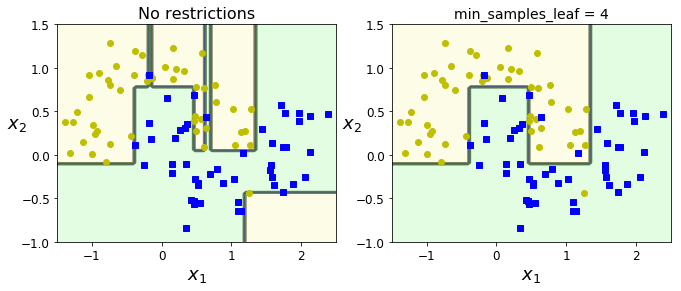

In [12]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from sklearn.svm import SVC
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)


def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.show()

## Playing around with regions

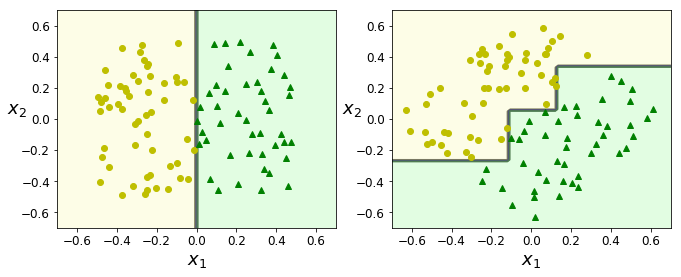

In [13]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi/4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

## Regression trees

In [14]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

## Final regressor code

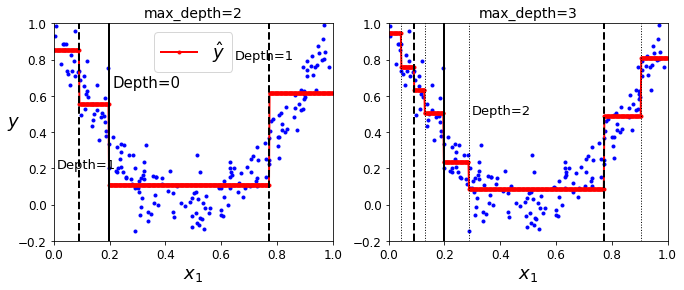

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

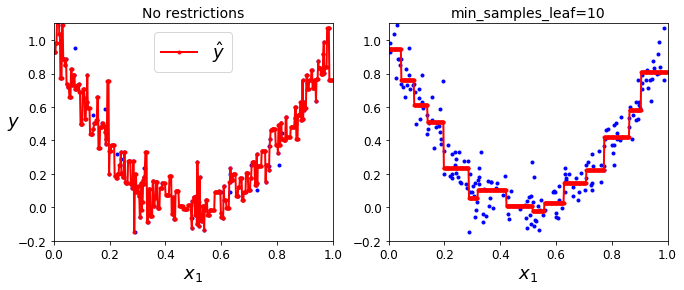

In [17]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## Pros and cons of trees, pros

* White box, easy to interpret model. Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches discussed earlier (think of support vector machines)

* Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!

* No feature normalization needed

* Tree models can handle both continuous and categorical data (Classification and Regression Trees)

* Can model nonlinear relationships

* Can model interactions between the different descriptive features

* Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small)

## Disadvantages

* Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches

* If continuous features are used the tree may become quite large and hence less interpretable

* Decision trees are prone to overfit the training data and hence do not well generalize the data if no stopping criteria or improvements like pruning, boosting or bagging are implemented

* Small changes in the data may lead to a completely different tree. This issue can be addressed by using ensemble methods like bagging, boosting or random forests

* Unbalanced datasets where some target feature values occur much more frequently than others may lead to biased trees since the frequently occurring feature values are preferred over the less frequently occurring ones. 

* If the number of features is relatively large (high dimensional) and the number of instances is relatively low, the tree might overfit the data

* Features with many levels may be preferred over features with less levels since for them it is *more easy* to split the dataset such that the sub datasets only contain pure target feature values. This issue can be addressed by preferring for instance the information gain ratio as splitting criteria over information gain

However, by aggregating many decision trees, using methods like bagging, random forests, and boosting, the predictive performance of trees can be substantially improved. 


## From a Single Tree to Many Trees, Meet the Jungle of Methods

As stated above and seen in many of the examples discussed here about
a single decision tree, we often end up overfitting our training
data. This normally means that we have a high variance. Can we reduce
the variance of a statistical learning method?

This leads us to a set of different methods that can combine different
machine learning algorithms or just use one of them to construct forests and jungles of trees, homogeneous ones or heterogenous ones. These methods are recognized by different names which we will try to explain here. These are
1. Voting classifiers

2. Bagging and Pasting

3. Random forests

4. Boosting methods

We discuss these methods here.

## Bagging

The **plain** decision trees suffer from high
variance. This means that if we split the training data into two parts
at random, and fit a decision tree to both halves, the results that we
get could be quite different. In contrast, a procedure with low
variance will yield similar results if applied repeatedly to distinct
data sets; linear regression tends to have low variance, if the ratio
of $n$ to $p$ is moderately large. 

**Bootstrap aggregation**, or just **bagging**, is a
general-purpose procedure for reducing the variance of a statistical
learning method. 


## More bagging

Bagging typically results in improved accuracy
over prediction using a single tree. Unfortunately, however, it can be
difficult to interpret the resulting model. Recall that one of the
advantages of decision trees is the attractive and easily interpreted
diagram that results.

However, when we bag a large number of trees, it is no longer
possible to represent the resulting statistical learning procedure
using a single tree, and it is no longer clear which variables are
most important to the procedure. Thus, bagging improves prediction
accuracy at the expense of interpretability.  Although the collection
of bagged trees is much more difficult to interpret than a single
tree, one can obtain an overall summary of the importance of each
predictor using the MSE (for bagging regression trees) or the Gini
index (for bagging classification trees). In the case of bagging
regression trees, we can record the total amount that the MSE is
decreased due to splits over a given predictor, averaged over all $B$ possible
trees. A large value indicates an important predictor. Similarly, in
the context of bagging classification trees, we can add up the total
amount that the Gini index  is decreased by splits over a given
predictor, averaged over all $B$ trees.

## Simple Voting Example, head or tail

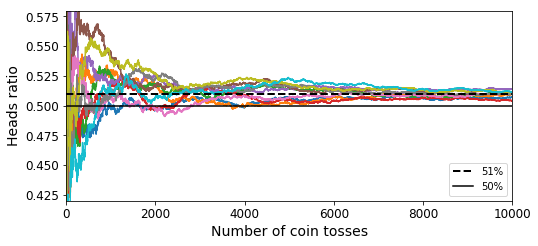

In [18]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

## Using the Voting Classifier

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896
LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## Please, not the moons again! Voting and Bagging

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [21]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: Fu

In [22]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [23]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: Fu

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## Now Bagging

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [26]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


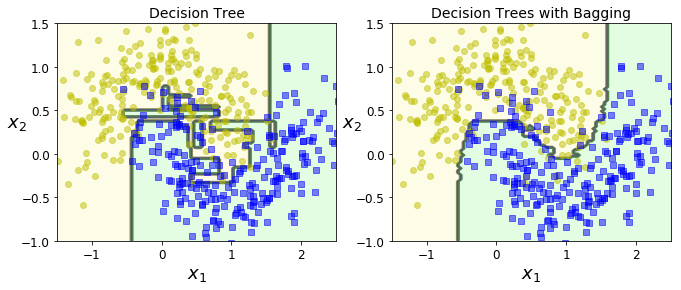

In [27]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Random forests

Random forests provide an improvement over bagged trees by way of a
small tweak that decorrelates the trees. 

As in bagging, we build a
number of decision trees on bootstrapped training samples. But when
building these decision trees, each time a split in a tree is
considered, a random sample of $m$ predictors is chosen as split
candidates from the full set of $p$ predictors. The split is allowed to
use only one of those $m$ predictors. 

A fresh sample of $m$ predictors is
taken at each split, and typically we choose

$$
m\approx \sqrt{p}.
$$

In building a random forest, at
each split in the tree, the algorithm is not even allowed to consider
a majority of the available predictors. 

The reason for this is rather clever. Suppose that there is one very
strong predictor in the data set, along with a number of other
moderately strong predictors. Then in the collection of bagged
variable importance random forest trees, most or all of the trees will
use this strong predictor in the top split. Consequently, all of the
bagged trees will look quite similar to each other. Hence the
predictions from the bagged trees will be highly correlated.
Unfortunately, averaging many highly correlated quantities does not
lead to as large of a reduction in variance as averaging many
uncorrelated quanti- ties. In particular, this means that bagging will
not lead to a substantial reduction in variance over a single tree in
this setting.


## Random Forest Algorithm
The algorithm described here can be applied to both classification and regression problems.

We will grow of forest of say $M$ trees.
1. For $m=1:M$ we

  * Draw a bootstrap sample of from the training data organized in our $\boldsymbol{X}$ matrix.

  * We grow then a random forest tree $T_m$ based on the bootstrapped data by repeating the steps outlined till we reach the maximum node size is reached

1. we select $m \le p$ varibales at random from the $p$ predictors/features

2. pick the best split point among the $m$ features using either the CART algorithm or the ID3 for classification and create a new node

3. split the node into daughter nodes



4. Output then the ensemble of trees $\{T_m\}_1^{M}$ and make predictions for either a regression type of problem or a classification type of problem. 

## Random Forests Compared with other Methods on the Cancer Data

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy with SVM: 0.63
Test set accuracy with Decision Trees: 0.87
Test set accuracy Logistic Regression with scaled data: 0.96
Test set accuracy SVM with scaled data: 0.96
Test set accuracy with Decision Trees and scaled data: 0.90


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[0.93333333 0.8        0.93333333 1.         1.         0.92857143
 1.         0.92857143 0.92857143 1.        ]
Test set accuracy with Random Forests and scaled data: 0.98


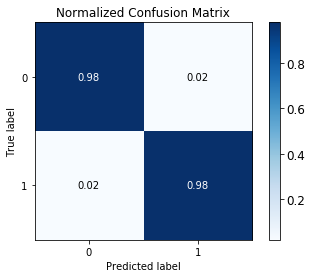

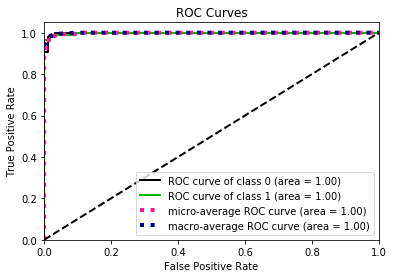

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


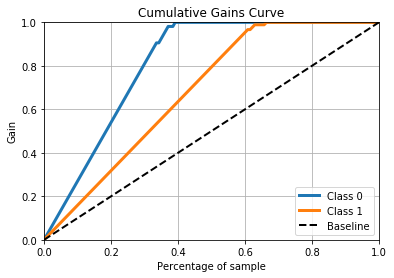

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
# Support vector machine
svm = SVC(gamma='auto', C=100)
svm.fit(X_train, y_train)
print("Test set accuracy with SVM: {:.2f}".format(svm.score(X_test,y_test)))
# Decision Trees
deep_tree_clf = DecisionTreeClassifier(max_depth=None)
deep_tree_clf.fit(X_train, y_train)
print("Test set accuracy with Decision Trees: {:.2f}".format(deep_tree_clf.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Support Vector Machine
svm.fit(X_train_scaled, y_train)
print("Test set accuracy SVM with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Decision Trees
deep_tree_clf.fit(X_train_scaled, y_train)
print("Test set accuracy with Decision Trees and scaled data: {:.2f}".format(deep_tree_clf.score(X_test_scaled,y_test)))


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
# Data set not specificied
#Instantiate the model with 500 trees and entropy as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=500,criterion="entropy")
Random_Forest_model.fit(X_train_scaled, y_train)
#Cross validation
accuracy = cross_validate(Random_Forest_model,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Random Forests and scaled data: {:.2f}".format(Random_Forest_model.score(X_test_scaled,y_test)))


import scikitplot as skplt
y_pred = Random_Forest_model.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
#<matplotlib.axes._subplots.AxesSubplot object at 0x7fe967d64490>
plt.show()
y_probas = Random_Forest_model.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

## Compare  Bagging on Trees with Random Forests

In [29]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [30]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.986013986013986

## Feature Importance

Example will be added here.


## Boosting, a Bird'e Eye

The basic idea is to combine weak classifiers in order to create a good
classifier. With a weak classifier we often intend a classifier which
produces results which are only slightly better than we would get by
random guesses.

This is done by applying in an iterative way a weak (or a standard
classifier like decision trees) to modify the data. In each iteration
we emphasize those observations which are misclassified by weighting
them with a factor.


## Adaptive boosting: AdaBoost, Basic Algorithm

The algorithm here is rather straightforward. Assume that our weak
classifier is a decision tree and we consider a binary set of outputs
with $y_i \in \{-1,1\}$ and $i=0,1,2,\dots,n-1$ as our set of
observations. Our design matrix is given in terms of the
feature/predictor vectors
$\boldsymbol{X}=[\boldsymbol{x}_0\boldsymbol{x}_1\dots\boldsymbol{x}_{p-1}$. Finally, we define also a
classifier determined by our data via a function $G(\boldsymbol{X})$. This function tells us how well we are able to classify our outputs/targets $\boldsymbol{y}$. 

We can then define the misclassification error $\mathrm{err}$ as

$$
\mathrm{err}=\frac{1}{n}\sum_{i=0}^{n-1}I(y_i\ne G(\boldsymbol{X}_{i*}),
$$

where the function $I()$ is one if we misclassify and zero if we classify correctly. 

## Basic Steps of AdaBoost

With the above definitions we are now ready to set up the algorithm for AdaBoost.
The basic idea is to set up weights which will be used to scale the correctly classified and the misclassified cases.
1. We start by initializing all weights to $w_i = 1/n$, with $i=0,1,2,\dots n-1$. It is to see then that $\sum_{i=0}^{n-1}w_i = 1$.

2. We rewrite the misclassification error as

$$
\mathrm{err}=\frac{\sum_{i=0}^{n-1}w_iI(y_i\ne G(\boldsymbol{X}_{i*})}{\sum_{i=0}^{n-1}w_i},
$$

1. Then we start looping over all attempts at classifying, namely we start an iterative process for $m=1:M$, where $M$ is the final number of classifications. Our given classifier could for example be a plain decision tree.

a. Fit thus a given classifier to the training using the weights $w_i$.

b. Compute then $\mathrm{err}$ and figure out which events are classified properly and which are classified wrongly.

c. Define a quantity $\alpha_{m} = \log{(1-\mathrm{err})/\mathrm{err}}

d. Set the new weights to $w_i = w_i\times \exp{(\alpha_m I(y_i\ne G(\boldsymbol{X}_{i*})}.


5. Compute the new classifier $G(\boldsymbol{X})= \sum_{i=0}^{n-1}\alpha_m I(y_i\ne G(\boldsymbol{X}_{i*}).

For the iterations with $m \le 2$ the weights are modified
individually at each steps. The obersvations which were misclassified
at iteration $m-1$ have a weight which is larger than those which were
classified properly. As this proceeds, the observations which were
difficult to classifiy correctly are given a larger influence. Each
new classificatio step $m$ is then forced to concentrate on those
observations that are missed in the previous iterations.

## Figure to Illustrate the Iterative Classification Process


## AdaBoost Examples

Using **Scikit-Learn** it is easy to appply the adaptive boosting algorithm, as done here.

In [33]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 30 and input n_features is 2 

## Gradient boosting: Basics

Gradient boosting is again a similar technique to Adapative boosting,
it combines so-called weak classifiers or regressors into a strong
method via a series of iterations.

In order to understand the method, let us illustrate its basics by
bringing back the essential steps in linear regression, where our cost
function was the least squares function.

## Gradient Boosting, algorithm

Suppose we have a cost function $C(f)=\sum_{i=0}^{n-1}L(y_i, f(x_i))$ where $y_i$ is our target and $f(x_i)$ the function which is meant to model $y_i$. The above cost function could be our standard least squares  function

$$
C(\boldsymbol{y},\boldsymbol{f})=\frac{1}{n}\sum_{i=0}^{n-1}(y_i-f(x_i))^2.
$$

The way we proceed in an iterative fashion is to
1. Initialize our estimate by $f_0(x)=0$.

2. For $m=1:M$, we

a. compute the negative gradient vector $\boldsymbol{u}_m = -\partial C(\boldsymbol{y},\boldsymbol{f})/\partial \boldsymbol{f}(x)$ at $f(x) = f_{m-1}(x);

b. fit the so-called base-learner to the negative gradient $h_m(u_m,x)$;

c. update the estimate $f_m(x) = f_{m-1}(x)+\nu h_m(u_m,x)$;


4. The final estimate is then $f_M(x) = \sum_{m=1}^M\nu h_m(u_m,x)$.

## Gradient Boosting, Examples

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boots with Early Stopping

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

min_error = np.min(errors)
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()


gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping


print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

## XGBoost: Extreme Gradient Boosting


[XGBoost](https://github.com/dmlc/xgboost) or Extreme Gradient
Boosting, is an optimized distributed gradient boosting library
designed to be highly efficient, flexible and portable. It implements
machine learning algorithms under the Gradient Boosting
framework. XGBoost provides a parallel tree boosting that solve many
data science problems in a fast and accurate way